# Import Libraries

In [1]:
import numpy as np
from datetime import datetime, timedelta
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Set History and Projection Data, and Months of Data

In [52]:
# Each time step is roughly 30 seconds - not all (1 hr = 120, 2 hrs = 240, 12 hrs = 1440, 24 hrs = 2880)

timesteps = 1440 # history 
corr_timestep = 120 # projection

sel_mon = 12

# Shaping Data

In [5]:
data = np.load('/Volumes/MARI/ssdl_gps/correction_data/correction_data_2019_minmaxscale_postoutlier.npz')
epochs = data['matching_epochs']
final_clock_bias = data['matching_clock_bias']
broadcast_clock_bias = data['matching_poly_values']
correction_value = data['correction_vals']

In [6]:
# limit data considered

no_mon = 12 # number of months considered (user defined)

mon_len = len(epochs)/12
tot_len = int(np.floor(no_mon * mon_len))

epochs = epochs[:tot_len]
final_clock_bias = final_clock_bias[:tot_len]
broadcast_clock_bias = broadcast_clock_bias[:tot_len]
correction_value = correction_value[:tot_len]

In [11]:
print(tot_len)
print(len(epochs))
print(len(final_clock_bias))
print(len(broadcast_clock_bias))
print(len(correction_value))

1895247
1895247
1895247
1895247
1895247


In [13]:
time_datetimes = [datetime.strptime(ts, '%Y:%m:%d:%H:%M:%S') for ts in epochs]
print(min(time_datetimes))
print(max(time_datetimes))

2018-12-30 00:00:00
2019-12-31 23:59:30


In [14]:
# # Iterate over the time_datetimes to check the time differences to see where interval is not 30 seconds
# for i in range(len(time_datetimes) - 1):
#     time_difference = (time_datetimes[i + 1] - time_datetimes[i]).total_seconds()
#     if time_difference not in [0, 30]:
#         print(f"Times where delta_time is not 0 or 30 seconds: B/w {time_datetimes[i]} & {time_datetimes[i+1]}, Idx: {i}, {i+1}")

In [18]:
x = [] # input
y = [] # labels 

In [20]:
len(broadcast_clock_bias)

1895247

In [22]:
range(timesteps,len(broadcast_clock_bias))

range(1440, 1895247)

In [24]:
for i in range(timesteps,len(broadcast_clock_bias)-corr_timestep):
    history = broadcast_clock_bias[i-timesteps:i]
    correction = correction_value[i:i+corr_timestep]
    # print(correction)
    x.append(history)
    y.append(correction)

In [27]:
x = np.array(x)
y = np.array(y)

In [29]:
print(x.shape)

(1893687, 1440)


In [31]:
print(y.shape)

(1893687, 120)


In [33]:
x = torch.Tensor(x)
y = torch.Tensor(y)

In [34]:
print(x.shape)
print(y.shape)

torch.Size([1893687, 1440])
torch.Size([1893687, 120])


In [37]:
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2)

In [39]:
print(f'Shape of X_temp: {x_temp.shape}')
print(f'Shape of X_test: {x_test.shape}')
print(f'Shape of y_temp: {y_temp.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_temp: torch.Size([1514949, 1440])
Shape of X_test: torch.Size([378738, 1440])
Shape of y_temp: torch.Size([1514949, 120])
Shape of y_test: torch.Size([378738, 120])


In [40]:
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, train_size=7/8)

In [43]:
print(f'Shape of X_train: {x_train.shape}')
print(f'Shape of X_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of X_train: torch.Size([1325580, 1440])
Shape of X_val: torch.Size([189369, 1440])
Shape of y_train: torch.Size([1325580, 120])
Shape of y_val: torch.Size([189369, 120])


In [45]:
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
test_dataset = TensorDataset(x_test,y_test)

In [47]:
torch.save(train_dataset, f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{no_mon}_train_dataset_step{timesteps}_corr{corr_timestep}.pt')
torch.save(val_dataset, f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{no_mon}_val_dataset_step{timesteps}_corr{corr_timestep}.pt')
torch.save(test_dataset, f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{no_mon}_test_dataset_step{timesteps}_corr{corr_timestep}.pt')

# Transformer Model

In [54]:
train = torch.load(f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{sel_mon}_train_dataset_step{timesteps}_corr{corr_timestep}.pt')
val = torch.load(f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{sel_mon}_val_dataset_step{timesteps}_corr{corr_timestep}.pt')
test = torch.load(f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{sel_mon}_test_dataset_step{timesteps}_corr{corr_timestep}.pt')

In [ ]:
# print(val[0][0].shape)
# print(val[0][1].shape)
# print(val[1][1].shape)
# print(len(val))
# print(len(val[1]))
# print(len(val[0][0]))

In [56]:
# Load Data
BS = 256

train_dataloader = DataLoader(train, batch_size = BS, shuffle = True)
val_dataloader = DataLoader(val, batch_size = BS, shuffle = False)
test_dataloader = DataLoader(test, batch_size = BS, shuffle = False)

In [58]:
print((len(train_dataloader)))
print((len(val_dataloader)))
print((len(test_dataloader)))

5179
740
1480


In [60]:
# https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891

In [62]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, output_dim):
        super(TransformerEncoderModel, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x.squeeze()  # Ensure the output has the correct shape

In [64]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [66]:
input_dim = timesteps  # Size of each input sample (timesteps)
d_model = 128  # Embedding dimension
nhead = 16  # Number of attention heads (Syam: 2)
num_layers = 12  # Number of transformer layers (Syam: 1)
dim_feedforward = 20  # Dimension of the feedforward network (hidden units)
dropout = 0.1
output_dim = corr_timestep  # Size of the output (correction value 240= 2 hours; was 1)

In [68]:
import math
model = TransformerEncoderModel(input_dim, d_model, nhead, num_layers, dim_feedforward, output_dim)

/Users/marilyn/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [70]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/15, Train Loss: 0.1895, Val Loss: 0.1884
Epoch 2/15, Train Loss: 0.1880, Val Loss: 0.1887
Epoch 3/15, Train Loss: 0.1880, Val Loss: 0.1883
Epoch 4/15, Train Loss: 0.1880, Val Loss: 0.1890
Epoch 5/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 6/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 7/15, Train Loss: 0.1880, Val Loss: 0.1883
Epoch 8/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 9/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 10/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 11/15, Train Loss: 0.1880, Val Loss: 0.1883
Epoch 12/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 13/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 14/15, Train Loss: 0.1879, Val Loss: 0.1883
Epoch 15/15, Train Loss: 0.1879, Val Loss: 0.1883


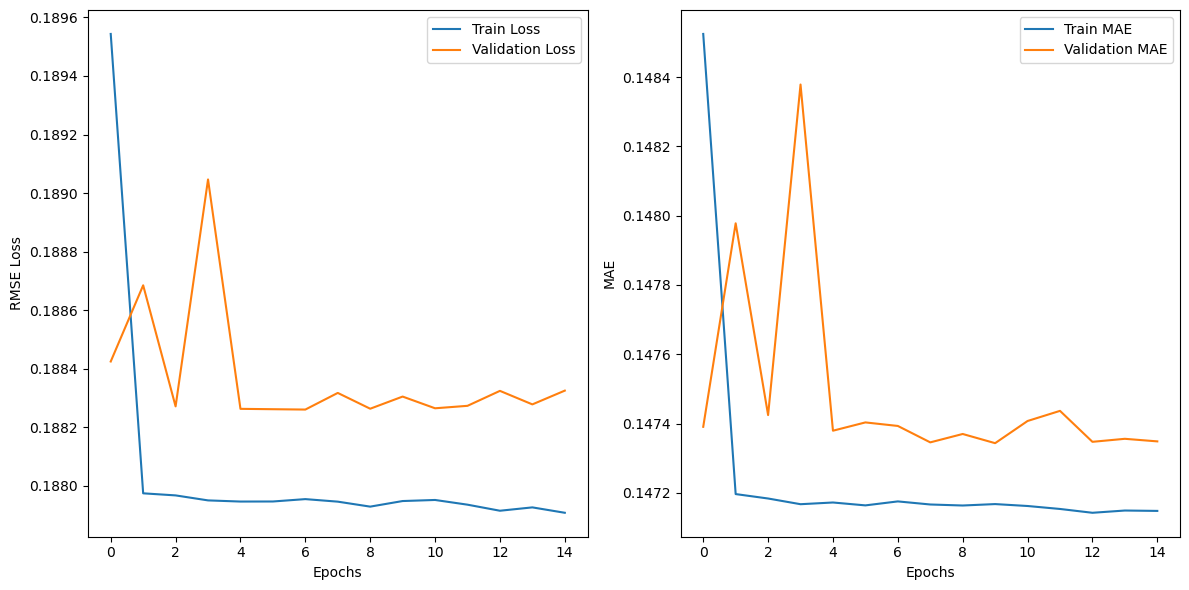

CPU times: user 8h 35min 18s, sys: 13h 14min 27s, total: 21h 49min 46s
Wall time: 4h 57min 24s


In [72]:
%%time

import matplotlib.pyplot as plt

EPOCHS = 15

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    train_mae = []
    val_mae = []

    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_actuals = []

        
        for X_train, y_train in train_dataloader:
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            all_train_preds.extend(outputs.detach().cpu().numpy())
            all_train_actuals.extend(y_train.detach().cpu().numpy())

        
        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        train_mae_val = mean_absolute_error(all_train_actuals, all_train_preds)
        train_mae.append(train_mae_val)

        
        model.eval()
        running_loss = 0.0
        all_val_preds = []
        all_val_actuals = []

        with torch.no_grad():
            for X_val, y_val in val_dataloader:
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                running_loss += loss.item()
                
                all_val_preds.extend(outputs.detach().cpu().numpy())
                all_val_actuals.extend(y_val.detach().cpu().numpy())

        
        val_loss = running_loss / len(val_dataloader)
        val_losses.append(val_loss)

        val_mae_val = mean_absolute_error(all_val_actuals, all_val_preds)
        val_mae.append(val_mae_val)

        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, train_mae, val_losses, val_mae

num_epochs = EPOCHS
train_losses, train_mae, val_losses, val_mae = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_mae, label='Train MAE')
plt.plot(range(num_epochs), val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
%%time

def evaluate_model(model, test_dataloader, criterion):
    model.eval()
    running_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_test, y_test in test_dataloader:
            outputs = model(X_test)
            loss = criterion(outputs, y_test)
            running_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_test.cpu().numpy())
    
    test_loss = running_loss / len(test_dataloader)
    mae = mean_absolute_error(actuals, predictions)

    return test_loss, mae, predictions, actuals

test_loss, mae, predictions, actuals = evaluate_model(model, test_dataloader, criterion)
print(f'Test RMSE Loss: {test_loss:.4f}')
print(f'Test MAE: {mae:.4f}')

Test RMSE Loss: 0.1881
Test MAE: 0.1471
CPU times: user 2min 12s, sys: 2min 11s, total: 4min 24s
Wall time: 39.6 s


378738
(120,)
(120,)
(120,)
378738


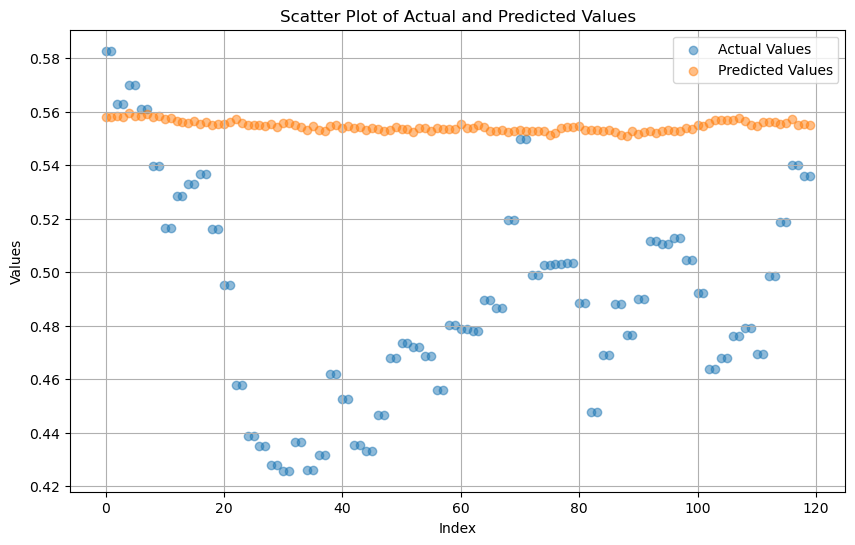

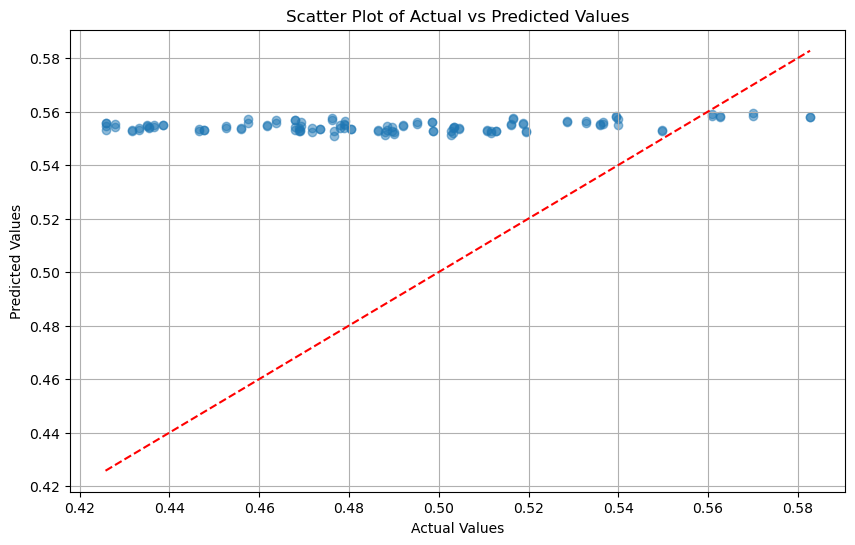

R² Score: -0.0010


In [76]:
print(len(actuals))
print(actuals[-1].shape)
print(actuals[2].shape)
print(predictions[0].shape)
print(len(predictions))

# Scatter plot of actual and predicted values on the same axis
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actuals[-1])), actuals[-1], alpha=0.5, label='Actual Values')
plt.scatter(range(len(predictions[-1])), predictions[-1], alpha=0.5, label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of Actual and Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(actuals[-1], predictions[-1], alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.plot([min(actuals[-1]), max(actuals[-1])], [min(actuals[-1]), max(actuals[-1])], 'r--')  # Add a diagonal line
plt.grid(True)
plt.show()

# Convert lists to numpy arrays
actuals_array = np.array(actuals)
predictions_array = np.array(predictions)

# Calculate R² score
r2 = r2_score(actuals_array, predictions_array)
print(f'R² Score: {r2:.4f}')

In [78]:
og_data = np.load('/Volumes/MARI/ssdl_gps/correction_data/correction_data_2019_outliers_1_99.npz')
og_final_clock_bias = og_data['matching_clock_bias']
og_broadcast_clock_bias = og_data['matching_poly_values']
og_correction_value = og_data['correction_vals']

In [79]:
og_final_clock_bias = og_final_clock_bias[:tot_len]
og_broadcast_clock_bias = og_broadcast_clock_bias[:tot_len]
og_correction_value = og_correction_value[:tot_len]

In [80]:
original_min = min(og_correction_value)
original_max = max(og_correction_value)

re_scaler = MinMaxScaler(feature_range=(original_min, original_max))

predictions_reshaped = predictions_array.reshape(-1, 1)
actuals_reshaped = actuals_array.reshape(-1, 1)
re_scaler.fit(np.vstack([predictions_reshaped, actuals_reshaped]))

predictions_rescaled = re_scaler.transform(predictions_reshaped).reshape(predictions_array.shape)
actuals_rescaled = re_scaler.transform(actuals_reshaped).reshape(actuals_array.shape)

mae_rescaled = mean_absolute_error(actuals_rescaled, predictions_rescaled)
rmse_rescaled =  np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))

In [83]:
print("MAE (ns):", mae_rescaled/1e-9)
print("RMSE (ns):", rmse_rescaled/1e-9)

MAE (ns): 0.7436284921169545
RMSE (ns): 0.9520656485406674


In [88]:
print("Max Actuals (s):", np.max(actuals_reshaped))
print("Max Predictions (s):", np.max(predictions_reshaped))
print("Min Actuals (s):", np.min(actuals_reshaped))
print("Min Predictions (s):", np.min(predictions_reshaped))

Max Actuals (s): 1.0
Max Predictions (s): 0.5594129
Min Actuals (s): 0.0
Min Predictions (s): 0.5508881


# Hyperparameter Optimization

In [ ]:
# from sklearn.model_selection import ParameterGrid
# # Define a parameter grid
# # param_grid = {
# #     'learning_rate': [0.0001, 0.001],
# #     'batch_size': [32, 64],
# #     'd_model': [8, 16],
# #     'nhead': [2, 4],
# #     'num_layers': [1, 2],
# #     'dim_feedforward': [10, 20],
# #     'num_epochs': [5, 10]
# # }

# param_grid = {
#     'learning_rate': [0.001],
#     'batch_size': [64],
#     'd_model': [8],
#     'nhead': [2],
#     'num_layers': [1],
#     'dim_feedforward': [10],
#     'num_epochs': [10]
# }

In [ ]:
# grid = list(ParameterGrid(param_grid))

In [ ]:
# best_r2 = float('-inf')
# best_params = None

In [ ]:
# %%time

# for params in grid:
#     print(f'Trying params: {params}')
    
#     # Create DataLoader with the current batch size
#     train_dataloader = DataLoader(train, batch_size=params['batch_size'], shuffle=True)
#     val_dataloader = DataLoader(val, batch_size=params['batch_size'], shuffle=False)
#     test_dataloader = DataLoader(test, batch_size=params['batch_size'], shuffle=False)
    
#     # Initialize the model with current hyperparameters
#     model = TransformerEncoderModel(input_dim, 
#                                     params['d_model'], 
#                                     params['nhead'], 
#                                     params['num_layers'], 
#                                     params['dim_feedforward'], 
#                                     output_dim)
    
#     # Define the optimizer with the current learning rate
#     optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
#     # Train the model
#     train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, params['num_epochs'])
    
#     # Evaluate the model
#     test_loss, predictions, actuals = evaluate_model(model, test_dataloader, criterion)
    
#     # Calculate R² score
#     actuals_array = np.array(actuals)
#     predictions_array = np.array(predictions)
#     r2 = r2_score(actuals_array, predictions_array)
    
#     print(f'R² Score: {r2:.4f}')
    
#     # Check if the current model is the best so far
#     if r2 > best_r2:
#         best_r2 = r2
#         best_params = params

# print(f'Best R² Score: {best_r2:.4f}')
# print(f'Best Parameters: {best_params}')

# Archive

In [ ]:
# import ray
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler

In [ ]:
# def train_transformer(config, checkpoint_dir=None):
#     # Load datasets
#     sel_mon = 12
#     train = torch.load(f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{sel_mon}_train_dataset.pt')
#     val = torch.load(f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{sel_mon}_val_dataset.pt')
#     test = torch.load(f'/Volumes/MARI/ssdl_gps/torch_datasets/mo{sel_mon}_test_dataset.pt')

#     train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
#     val_dataloader = DataLoader(val, batch_size=64, shuffle=False)
#     test_dataloader = DataLoader(test, batch_size=64, shuffle=False)

#     # Initialize model, criterion, optimizer
#     model = TransformerEncoderModel(
#         input_dim=240,
#         d_model=config["d_model"],
#         nhead=config["nhead"],
#         num_layers=config["num_layers"],
#         dim_feedforward=config["dim_feedforward"],
#         output_dim=1
#     )
    
#     criterion = RMSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=config["lr"])

#     if checkpoint_dir:
#         checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pth"))
#         model.load_state_dict(checkpoint["model_state_dict"])
#         optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

#     # Training loop
#     for epoch in range(10):  # You can make this configurable
#         model.train()
#         running_loss = 0.0
#         for X_train, y_train in train_dataloader:
#             optimizer.zero_grad()
#             outputs = model(X_train)
#             loss = criterion(outputs, y_train)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
        
#         train_loss = running_loss / len(train_dataloader)
        
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for X_val, y_val in val_dataloader:
#                 outputs = model(X_val)
#                 loss = criterion(outputs, y_val)
#                 val_loss += loss.item()
        
#         val_loss /= len(val_dataloader)
        
#         tune.report(loss=val_loss)
        
#         if epoch % 5 == 0:
#             with tune.checkpoint_dir(epoch) as checkpoint_dir:
#                 path = os.path.join(checkpoint_dir, "checkpoint.pth")
#                 torch.save({
#                     "model_state_dict": model.state_dict(),
#                     "optimizer_state_dict": optimizer.state_dict()
#                 }, path)

# # Define search space
# config = {
#     "d_model": tune.choice([8, 16, 32]),
#     "nhead": tune.choice([2, 4]),
#     "num_layers": tune.choice([2, 4]),
#     "dim_feedforward": tune.choice([10, 20, 50]),
#     "lr": tune.loguniform(1e-4, 1e-2)
# }

# # Run hyperparameter tuning
# scheduler = ASHAScheduler(
#     metric="loss",
#     mode="min",
#     max_t=10,
#     grace_period=1,
#     reduction_factor=2
# )

# analysis = tune.run(
#     train_transformer,
#     resources_per_trial={"cpu": 2},
#     config=config,
#     num_samples=10,
#     scheduler=scheduler
# )

# print("Best config: ", analysis.best_config)